## **Aplicação de Random Forest Regression**
Neste notebook será aplicado o modelo Random Forest Regression utilizando as features extraídas dos dados .
Para avaliação do desempenho do modelo, serão utilizadas as métricas **MAE**, **MSE**, **RMSE** e **R²**, comparados aos modelos benchmark **SARIMA**, **ETS** e **Regressão Linear**. 

In [1]:
# confirgurando diretório
import sys
import os
sys.path.append(os.path.abspath('..'))

# importando bibliotecas
import warnings
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
from xgboost import XGBRegressor
from src.features import add_trend
from src.evaluation import Evaluation
from src.plots import plot_time_series

# configurando notebook
tqdm.pandas()
warnings.filterwarnings("ignore")
pd.set_option('display.float_format', lambda x: '%.2f' % x)


%load_ext autoreload
%autoreload 2

EVAL_PATH = '../data/evaluation.csv'

## **Leitura dos Dados**

In [2]:
# leitura dos dados
train_df = pd.read_csv("../data/features_train_df.csv", parse_dates=['ds'], index_col=[0])
test_df = pd.read_csv("../data/features_test_df.csv", parse_dates=['ds'], index_col=[0])

In [4]:
import json

with open("../data/features.json", "r", encoding="utf-8") as arquivo:
    selected_features = json.load(arquivo)

In [5]:
best_models = {}

params= {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8, 0.9, 1.0],   
    'colsample_bytree': [0.8, 0.9, 1.0]
}

In [6]:
def grid_search(estimator, X, y):
    splitter = TimeSeriesSplit(n_splits=3)
    search = GridSearchCV(
        cv=splitter,
        estimator=estimator,
        param_grid=params,
        scoring='neg_mean_squared_error',
        n_jobs=-1,
    )
    search.fit(X, y)
    return search.best_params_


def xgboost(df : pd.DataFrame) -> pd.DataFrame:
    """
    Aplicação do modelo RandomForest.
    """    
    train = df.copy().reset_index(drop=True)
    fcst_df = test_df.query("unique_id == @train.unique_id[0]").reset_index(drop=True)

    train, fcst_df = add_trend(train, fcst_df)
    
    features = selected_features[train.unique_id[0]]
    best_model = grid_search(
        estimator=XGBRegressor(random_state=1001),
        X=train[features], 
        y=train.y
    )
    best_models[train.unique_id[0]] = best_model
    
    # best model fit_predict
    m = XGBRegressor(**best_model)
    m.fit(X=train[features], y=train.y)
    fcst_df['y_pred'] = m.predict(fcst_df[features])

    return fcst_df

In [7]:
# aplicando modelo para cada série
xgb_fcst = train_df.groupby("unique_id")\
    .progress_apply(xgboost)\
    .reset_index(drop=True)

100%|██████████| 14/14 [45:28<00:00, 194.89s/it]


In [9]:
with open("../data/xgboost_best_model.json", "w", encoding="utf-8") as arquivo:
    json.dump(best_models, arquivo, ensure_ascii=False, indent=4)

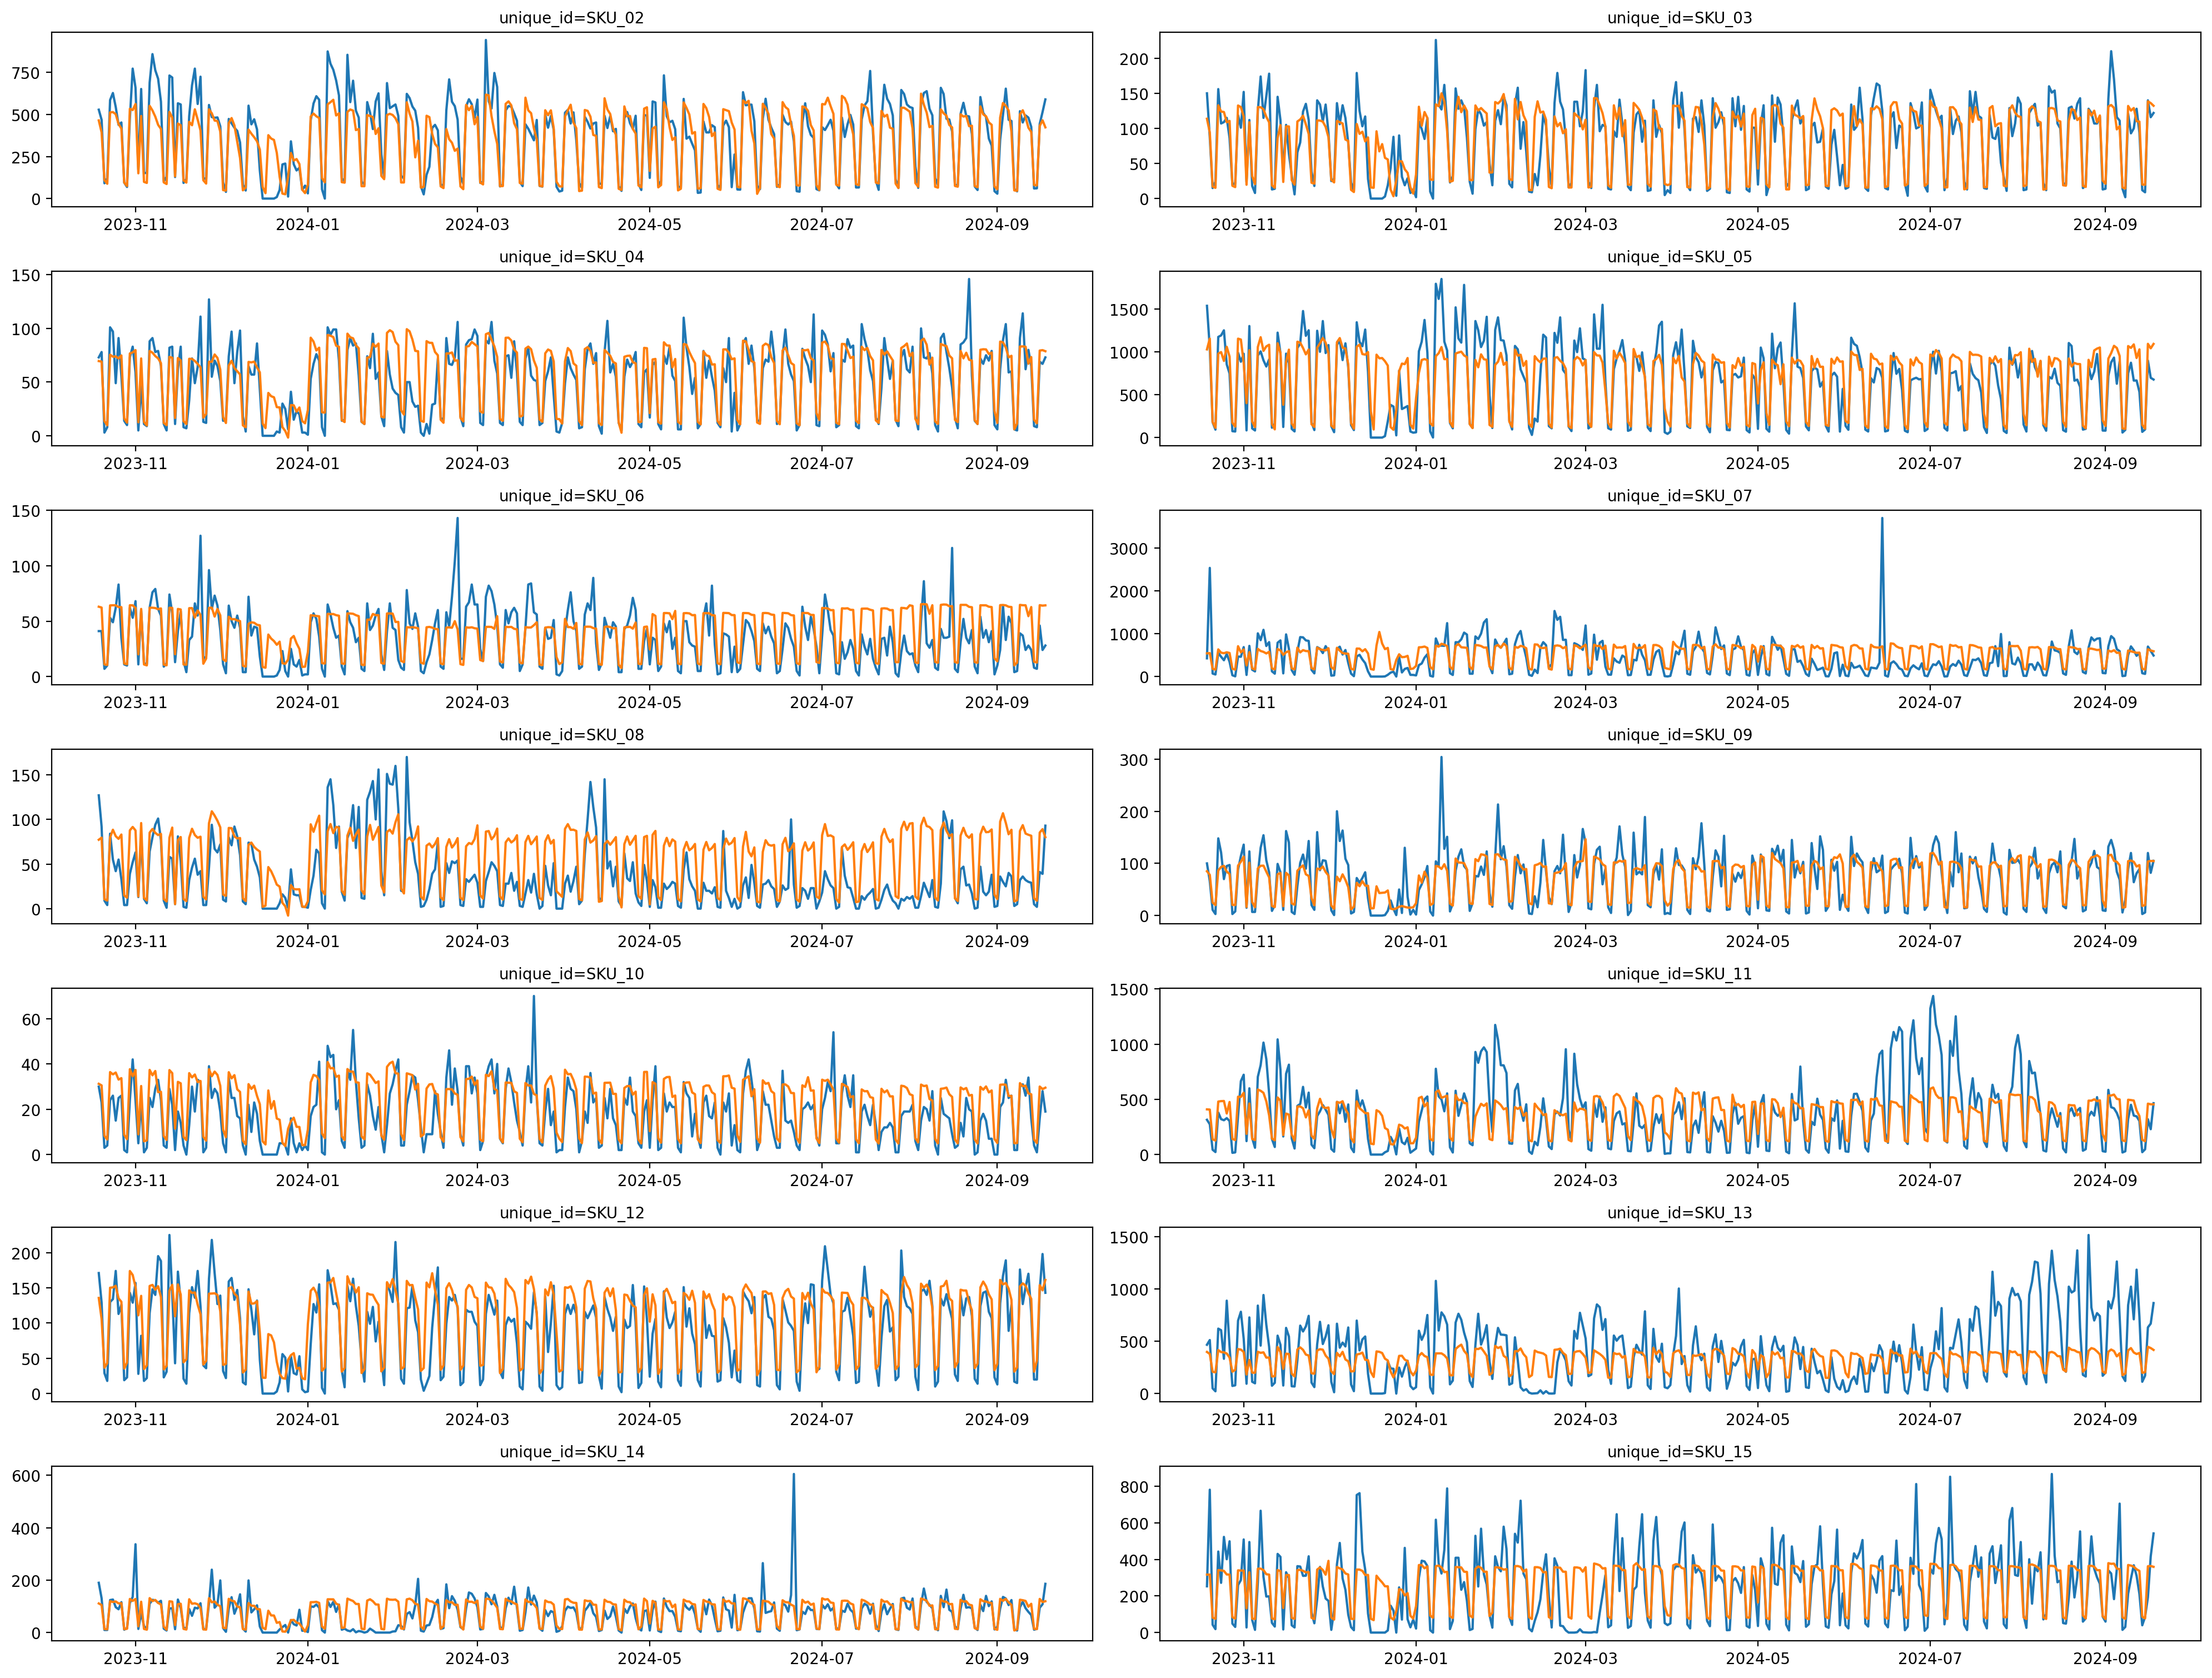

In [10]:
plt.rcParams["figure.dpi"] = 200

fig = plot_time_series(
    df=xgb_fcst, 
    figsize=(20, 16),
    data_cols=['y', 'y_pred'], 
)

In [11]:
rf_eval = Evaluation(xgb_fcst)
rf_eval.summary()
rf_eval.save_evaluation(EVAL_PATH, 'XGBoost')
rf_eval.evaluation_df

,mae,mse,rmse,r2
SKU_02,78.82,12935.67,113.74,0.75
SKU_03,18.94,733.83,27.09,0.74
SKU_04,13.26,359.38,18.96,0.68
SKU_05,179.56,65054.77,255.06,0.67
SKU_06,15.38,408.54,20.21,0.35
SKU_07,239.75,119283.89,345.38,0.27
SKU_08,30.90,1498.10,38.71,-0.16
SKU_09,20.85,940.86,30.67,0.65
SKU_10,7.92,99.58,9.98,0.38
SKU_11,160.20,49961.42,223.52,0.46


In [12]:
# comparação dos modelos
metrics = pd.read_csv(EVAL_PATH)
order = metrics['model'].unique()
metrics = metrics.pivot_table('r2','unique_id','model')[order]
metrics.T

unique_id,SKU_02,SKU_03,SKU_04,SKU_05,SKU_06,SKU_07,SKU_08,SKU_09,SKU_10,SKU_11,SKU_12,SKU_13,SKU_14,SKU_15
model,,,,,,,,,,,,,,
Naive Sazonal,0.09,-0.04,0.21,-0.45,0.08,-0.02,-1.22,-0.05,-0.80,-0.08,-0.25,-0.15,-0.05,-0.96
SARIMA,0.64,0.63,0.50,0.46,0.27,-0.79,-0.92,0.00,0.28,0.39,0.51,-0.01,0.21,-0.02
ETS,0.65,0.63,0.58,0.35,0.38,0.16,-0.93,0.53,-0.13,0.26,0.55,0.34,0.30,0.43
Decision Tree,0.57,0.53,0.45,0.57,0.21,0.29,-0.43,0.44,-0.18,0.20,0.33,0.32,0.27,0.17
XGBoost,0.75,0.74,0.68,0.67,0.35,0.27,-0.16,0.65,0.38,0.46,0.64,0.24,0.38,0.49
